In [1]:
from jax import grad, jit, vmap, pmap, random
import jax.numpy as jnp

In [1]:
# Jax is a lib for scientific computation
# It offer a nucdmpy-like API, but with automatic differentiation and GPU support
# It is also a great tool for parallel computing
arr=jnp.arange(10)
arr,type(arr)

NameError: name 'jnp' is not defined

## `Jax Design`

- Jax is designed to work with pure functions
- This means that the output of a function should only depend in its input
- This is because Jax uses jit compilation to speed up computations
- Jit compilation means that the function is compiled the first time it is called, and then the compiled version is used -or subsequent calls
- This is done by tracing the computation graph and then traversing it
- This means that the function must be deterministic

- Secondly, jax don't support in-place operations
- One need to use `.at[]` & `.set()` to perform any sort of modification,which will lead to a new array being created.

- Finally, jax work in asynchronous manner, which means that jax won't wait for the computation to finish before moving on to the next line of code.
- This is done to allow for parallel computing and efficient use of resources.
- One need to use `print()` or `block_until_ready()` methods if one wants to wait for the computation to finish before moving on to the next line of code.


In [41]:
# Impure function: Function that are statefull, or that have side effects. They mutate the state of program. There is no gurantee that the output will be the same for the same input.
state=0

def impure_func(x:int):
     # impure as using the state 
    return x+state

def pure_func(x:int,state:int):
    new_state=state+x
    return new_state,new_state

print(f"Impure function: {impure_func(10)}")
print(f"Pure function: {pure_func(10,state=0)}")

Impure function: 10
Pure function: (10, 10)


In [42]:
# Let see the difference,when we jit-compile the functions
impure_jit=jit(impure_func)
pure_jit=jit(pure_func)

print(f"Impure function: {impure_jit(10)}")
print(f"Pure function: {pure_jit(10,state=0)}")

# mutate the state 
state=20
print(f"Impure function: {impure_jit(10)}") # This will print 10, instead of 30 as state is never traced by jit as not part of func
print(f"Pure function: {pure_jit(10,state=state)}")

Impure function: 10
Pure function: (Array(10, dtype=int32, weak_type=True), Array(10, dtype=int32, weak_type=True))
Impure function: 10
Pure function: (Array(30, dtype=int32, weak_type=True), Array(30, dtype=int32, weak_type=True))


In [43]:
# Let see the trace for both functions
from jax import make_jaxpr
print(f"Impure trace: {make_jaxpr(impure_func)(10)}") # This is saying add 0 (init state) to var
print(f"Pure trace: {make_jaxpr(pure_func)(10,0)}") # This is saying add b to a

Impure trace: { lambda ; a:i32[]. let b:i32[] = add a 0 in (b,) }
Pure trace: { lambda ; a:i32[] b:i32[]. let c:i32[] = add b a in (c, c) }


In [45]:
# Note: In Jax when one tries to access out of bound index, it will clip the index to the last valid index, unlike numpy which throws an error
# This behavior of JAX can lead to errors in code, as one may not be aware of it if not carefull.

arr=jnp.arange(3)
print(arr[10]) # This will print 2


2


In [46]:
# Note Jax run the code in an aysnchronous manner, this means that the code will be executed in parallel, and the result will be returned when it is ready.
# This is done to take advantage of the GPU, and to speed up the computation.
# This is done by using XLA (Accelerated Linear Algebra) in JAX, which is a domain-specific compiler for linear algebra that can target GPUs and TPUs.
# Use .block_until_ready() function to wait for the computation to finish and return the result.

# Create two random matrices
key=random.key(0)
mat1 = random.normal(key,(1000, 1000))
mat2 = random.normal(key,(1000, 1000))

%timeit (mat1 @ mat2).block_until_ready()

28.8 ms ± 3.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [47]:
import jax
import jax.numpy as jnp
from jax import random, jit, block_until_ready

def fn(W, b, x):
    return x @ W + b

# Initialize the random key
key = random.PRNGKey(0)

# Split the key for generating different random values
key, w_key, b_key, x_key = random.split(key, 4)

# Generate random values for W, b, and x
W = random.normal(w_key, (4, 2))
b = random.uniform(b_key, (2,))
x = random.normal(x_key, (4,))

# Measure the time for the original function
print("`fn` time")
%timeit fn(W, b, x).block_until_ready()

# Create the jitted version of the function
jit_fn = jit(fn)

# Measure the time for the first call of the jitted function
print("`jax.jit(fn)` first call time")
%time jit_fn(W, b, x).block_until_ready()

# Measure the time for subsequent calls of the jitted function
print("`jit_fn` time")
%timeit jit_fn(W, b, x).block_until_ready()

`fn` time
74.5 μs ± 11.8 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
`jax.jit(fn)` first call time
CPU times: total: 62.5 ms
Wall time: 49.7 ms
`jit_fn` time
20.1 μs ± 3.25 μs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## `Random Number Generation`

### JAX Random Number Generation:
- JAX uses a PRNG (Pseudo-Random Number Generator) key for random number generation. This key allows for reproducible and parallel-friendly random number generation.
- When you split a PRNG key in JAX, you create independent streams of random numbers. This ensures that parallel processes can generate different sets of random numbers without interference.

### NumPy Random Number Generation:
- NumPy traditionally uses a global state for random number generation. This can lead to issues in parallel settings because the global state is shared among all processes.
- If you call numpy.random functions from multiple threads or processes simultaneously, you might encounter race conditions or other synchronization issues, potentially leading to the same sequence of random numbers being generated.

In [48]:
# In numpy we need to reset the gloabal set every time we need to generate the same number
import numpy as np

np.random.seed(0)
print(np.random.rand(3))  # The function will consume the seed and move it to next value in PRNG sequence

np.random.seed(0)
print(np.random.rand(3))

# In numpy creating n random numbers will consume n values in PRNG sequence no matter how u generate them,one-by-one or all n values at once
np.random.seed(0)
out1=[np.random.rand() for _ in range(3)]

np.random.seed(0)
out2=np.random.rand(3)
print(f"out1:{out1},out2:{out2}")

[0.5488135  0.71518937 0.60276338]
[0.5488135  0.71518937 0.60276338]
out1:[0.5488135039273248, 0.7151893663724195, 0.6027633760716439],out2:[0.5488135  0.71518937 0.60276338]


In [49]:
# In Jax we need to use PRNG key for random number generation
# PRNG key is a 2-element array of 32-bit unsigned integers
key=random.key(0)
print(f"key:{key}")

# Produce same number as we are using same key-every time
print(random.normal(key,shape=(3,)))
print(random.normal(key,shape=(3,)))


# To have numpy like behavior pass different key everytime you want to have this behaviour
key1,key2=random.split(key)
print(random.normal(key1,shape=(3,)))
print(random.normal(key2,shape=(3,)))


# Note: Here for creating n random-values, we can either consume n different keys or can use 1 key only for n random number gen
# Using 1 key
out1=random.normal(key,(3,))
out2=[]
for i in range(3):
    key,subkey=random.split(key)
    out2.append(random.normal(subkey))

print(f"out1:{out1}")
print(f"out2:{out2}")

key:Array((), dtype=key<fry>) overlaying:
[0 0]
[ 1.8160863  -0.48262316  0.33988908]
[ 1.8160863  -0.48262316  0.33988908]
[ 0.13893168  0.509335   -0.53116107]
[ 1.1378784  -1.2209548  -0.59153634]
out1:[ 1.8160863  -0.48262316  0.33988908]
out2:[Array(-1.2515389, dtype=float32), Array(-0.58665055, dtype=float32), Array(0.48648307, dtype=float32)]


## `Gradients:`

In [50]:
# Gradient of a function is the derivative of the function with respect to its input
# Jax provides a function called `grad` to compute the gradient of a function
# Jax grad takes a function as input and returns a function that computes the gradient of the input function
# Note: grad is used for scalar-valued functions, use jacobian for vector-valued functions

def func(x):
    return jnp.sum(x**2 + x*2)

grad_func=grad(func)

print("grad:",grad_func(jnp.array([1.,2.,3.]))) # answer : 2x+2 => [4,6,8]

# Other way
from jax import value_and_grad
val,grd=value_and_grad(func)(jnp.array([1.,2.,3.])) # ans: sum(func([1,2,3]),grad([1,2,3])

print(f"value:{val}, grad:{grd}")

grad: [4. 6. 8.]
value:26.0, grad:[4. 6. 8.]


## `Vectorization & Parallelization`

- Jit hels us to vectorize and parallelize our code
- Vectorization means that we can apply a function to a vector of inputs instead of applying it -o a single input (vmap)
- Parallelization means that we can apply a function to a vector of inputs in parallel instead of sequentially (pmap)

In [52]:
# -- vmap --
# vmap is a function that takes a function and a vector of inputs and applies the function to each input in the vector
# Help in batched computation
from jax import Array
def convolve(x:Array,wt:Array)->Array:
    len_x,len_w=len(x),len(wt)
    out=[]
    for i in range(len_x-len_w+1):
        out.append(jnp.sum(x[i:i+len_w]*wt))
    return jnp.array(out)

x=jnp.array([1.,2.,3.,4.,5.])
wt=jnp.array([1.,2.])

print(f"Simple Conv:{convolve(x,wt)}")

# But if we have batch of input we can direclty use vmap,rather than re-writting function again
bx=jnp.array([[1.,2.,3.,4.,5.],[6.,7.,8.,9.,10.]])
wt=jnp.array([1.,2.])

print(f"Vmap Conv:{vmap(convolve,in_axes=(0,None),out_axes=(0))(bx,wt)}")



Simple Conv:[ 5.  8. 11. 14.]
Vmap Conv:[[ 5.  8. 11. 14.]
 [20. 23. 26. 29.]]


### `Understanding in_axes and out_axes` 
1. **in_axes**: This parameter specifies which axes of the input arguments should be mapped over. It is a tuple where each element corresponds to an axis of the respective input argument. The value can be:

    - None: The argument is not mapped over.
    - int: The axis of the argument to be mapped over.

2. **out_axes**: This parameter specifies which axes of the output arguments should be mapped over. It is a tuple where each element corresponds to an axis of the respective output argument. The value can be:

    - None: The output is not mapped over.
    - int: The axis of the output to be mapped over.

In [53]:
def add(x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    return x + y

# Example arrays
x = jnp.array([1., 2., 3., 4., 5.])
y = jnp.array([5., 4., 3., 2., 1.])

# Simple addition
print(f"Simple Addition: {add(x, y)}")

# Now let's create batches of these arrays
bx = jnp.array([[1., 2., 3., 4., 5.], [6., 7., 8., 9., 10.]])
by = jnp.array([[5., 4., 3., 2., 1.], [10., 9., 8., 7., 6.]])

# Using vmap to perform batch addition
# in_axes=(0, 0) means we are mapping over the first axis (batch dimension) of both x and y
# out_axes=0 means the output will have the batch dimension as the first axis
result = vmap(add, in_axes=(0, 0), out_axes=0)(bx, by)

print(f"Vmap Addition: {result}")

# Let's consider another scenario where y is not batched
# in_axes=(0, None) means we are mapping over the first axis of x, but not mapping over y
# out_axes=0 means the output will have the batch dimension as the first axis
y_single = jnp.array([5., 4., 3., 2., 1.])
result_single = vmap(add, in_axes=(0, None), out_axes=0)(bx, y_single)

print(f"Vmap Addition with Single y: {result_single}")


Simple Addition: [6. 6. 6. 6. 6.]
Vmap Addition: [[ 6.  6.  6.  6.  6.]
 [16. 16. 16. 16. 16.]]
Vmap Addition with Single y: [[ 6.  6.  6.  6.  6.]
 [11. 11. 11. 11. 11.]]


In [54]:
# pmap is similar to vmap just across multiple devices
# pmap is a function that takes a function and a vector of inputs and applies the function to each input in the vector in parallel
# Help in distributed computation

## jit: `Just-In-Time Compilation`
- JIT is a technique that compiles a function into a more efficient version of the function that can be executed faster.
- JIT is used to optimize the performance of a function by compiling it into a more efficient version of the function that can be executed faster.
- JIT works with pure functions only.It first trace the function and then compile it.
- JIT is used to optimize the performance of a function by compiling it into a more efficient version of the function that can be executed faster.
- The tracer use the dtype and shape of input to decide wehther to compile the function or not.

In [55]:
def mse(target:jnp.ndarray,pred:jnp.ndarray)->jnp.ndarray:
    return jnp.mean((target-pred)**2)

jitted_mse=jit(mse)


In [56]:
%%timeit
mse(jnp.ones((1000,1000)),jnp.zeros((1000,1000)))

10.9 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
temp=jitted_mse(jnp.ones((1000,1000)),jnp.zeros((1000,1000))) # for tracing

In [58]:
%%timeit
jitted_mse(jnp.ones((1000,1000)),jnp.zeros((1000,1000))) # Note: here we are using cpu,but jax jit best performs in an accelerated enviorment like gpu/tpu

5.68 ms ± 215 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Note: _jax only runs for function without any side-effects, and only depends on dtype and shape of the input, so if u try to jit-compile a function whic depends on value of the input, it will not work._

In [59]:
def func_with_sideeffect(x):
    print("Executing function") # This will not-be traced and hence only printed the first time jax create trace for this funct,for subseuqent calls it will not print
    return x

jitted_func_with_sideeffect = jit(func_with_sideeffect)

# This will print "Executing function" every time
print(func_with_sideeffect(1))

# This will print "Executing function" only once
print(jitted_func_with_sideeffect(1))
print(jitted_func_with_sideeffect(2))

Executing function
1
Executing function
1
2


In [60]:
global_state=0
def func_depending_on_globalstate(x):
    return x+global_state # global_state will not be traced and tracked

jitted_func=jit(func_depending_on_globalstate)

print(jitted_func(1))
global_state=10 # This will not be reflected in the jitted function
print(jitted_func(1))

1
1


In [61]:
# We can't jit a func which depends on value of the input
def func(x):
    if x>0:
        return x+1
    else:
        return x-1

jitted_func=jit(func)

try:
    print(jitted_func(1))
except Exception as e:
    print(f"Can't jit the func: {e}")

Can't jit the func: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function func at C:\Users\admin\AppData\Local\Temp\ipykernel_7512\2965334908.py:2 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError


In [62]:
# We can't use loops that depends on value of input inside jit

# Can't be jitted as depnds on value of x
def func1(x):
    y=0
    for i in range(x):
        y+=1
    return y

# loop depends on some static val so valid
def func2(x):
    y=0
    for i in range(10):
        y+=1
    return y

# loop depends on shape of input only so valid
def func3(x):
    y=0
    for i in range(x.shape[0]):
        y+=x[i]
    return y


try:
    jitted_func1=jit(func1)
    jitted_func(10)
except Exception as e:
    print(f"func1 Can't be jitted the func1: {e}")


jitted_func2=jit(func2)
print(jitted_func2(1))



func1 Can't be jitted the func1: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function func at C:\Users\admin\AppData\Local\Temp\ipykernel_7512\2965334908.py:2 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError
10


### `Control Flow and logical operators wit JIT`

In [63]:
# How to jit a func that depends on value of some input
# We can use static_argnums/static_argnames parameter to specify the parameters for which we want to trace the value. 
# Anytime its value changes jax will re-complie th function.
# This can be usefull if static_arg take finite no. of values as jax will cache them in backend


def func1(x):
    y=0
    for i in range(x):
        y+=i
    return y

try:
    jitted_func1=jit(func1,static_argnames='x')
    print(jitted_func1(10))
except Exception as e:
    print(f"Can't jit func1: {e}")

45


# Structured control flow primitives
There are more options for control flow in JAX. Say you want to avoid re-compilations but still want to use control flow that’s traceable, and that avoids un-rolling large loops. Then you can use these 4 structured control flow primitives:

- `lax.cond`: differentiable

- `lax.while_loop`: fwd-mode-differentiable

- `lax.fori_loop`: fwd-mode-differentiable in general; fwd and rev-mode differentiable if endpoints are static.

- `lax.scan`: differentiable

In [64]:
from jax import lax

# These all can be jitted

# conditions: lax.cond(pred,true_func,false_func,operand)
operand = jnp.array([0.])
print(f"cond:True->{lax.cond(True, lambda x: x+1, lambda x: x-1, operand)}")
print(f"cond:False->{lax.cond(False, lambda x: x+1, lambda x: x-1, operand)}")
print("="*15)

# while-loop:lax.while_loop(cond_func,body_func,initial_val)
init_val = 0
cond_fun = lambda x: x < 10
body_fun = lambda x: x+1
print(lax.while_loop(cond_fun, body_fun, init_val))
print("="*15)

# for-loop: lax.fori_loop(start,stop,body_func,init_val)
init_val = 0
start = 0
stop = 10
body_fun = lambda i,x: x+i
print(lax.fori_loop(start, stop, body_fun, init_val))
print("="*15)

# lax.select: batched version of lax.cond; lax.select(pred_arr,on_true_arr,on_false_arr)
operand_true = jnp.array([1.0, 2.0, 3.0]) # should have same shape as pred_arr
operand_false = jnp.array([-1.0, -2.0, -3.0]) # should have same shape as pred_arr

# Selector array
selector = jnp.array([True, False, True])

# Use lax.select
print(lax.select(selector, operand_true, operand_false))
print("="*15)

cond:True->[1.]
cond:False->[-1.]
10
45
[ 1. -2.  3.]


In [65]:
## Logical operators:

# jax.numpy provides logical_and, logical_or, and logical_not, which operate element-wise on arrays and can be evaluated under jit without recompiling. Like their Numpy counterparts, the binary operators do not short circuit. Bitwise operators (&, |, ~) can also be used with jit.

def python_check_positive_even(x):
  is_even = x % 2 == 0
  # `and` short-circults, so when `is_even` is `False`, `x > 0` is not evaluated.
  return is_even and (x > 0)

@jit
def jax_check_positive_even(x):
  is_even = x % 2 == 0
  # `logical_and` does not short circuit, so `x > 0` is always evaluated.
  return jnp.logical_and(is_even, x > 0)

print(python_check_positive_even(24))
print(jax_check_positive_even(24))

# when the JAX version with logical_and is applied to an array, it returns elementwise values.
x = jnp.array([-1, 2, 5])
print(jax_check_positive_even(x))

True
True
[False  True False]


## `PyTrees:`
### What are Pytrees?

Pytrees are a way to represent nested data structures in JAX.

They are composed of container-like Python objects (e.g., lists, tuples, dictionaries) that hold numerical data (arrays, scalars).

They are used extensively in JAX for managing model parameters, state, and other data.


### Why use Pytrees?
- JAX functions operate on Pytrees seamlessly.

- They provide structure for complex data, making it easier to manage and manipulate.

- They are compatible with JAX transformations like jit, grad, vmap, etc.

### Common Pytree operations:

- `jax.tree.map`: similar to map in python but for pytrees leaves
- `jax.tree.reduce:` similar to reduce,but apply function over pytree leaves.
- `jax.tree.flatten`: flattens a pytree into a list of leaves and a treedef.

In [66]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Print how many leaves the pytrees have.
for pytree in example_trees:
  # This `jax.tree.leaves()` method extracts the flattened leaves from the pytrees.
  leaves = jax.tree.leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

  # See,how the elements inside tuple is unrolled to create leaves but not jax.Array

[1, 'a', <object object at 0x0000028B3F38B010>] has 3 leaves: [1, 'a', <object object at 0x0000028B3F38B010>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves: [Array([1, 2, 3], dtype=int32)]


In [67]:
# some common functions
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])

# structure
print(f"structure:{jax.tree.structure(params)}\n")

# leaves
# print(f"leaves:{jax.tree.leaves(params)}\n") # will print all leaves

# map
print(f"map:{jax.tree.map(lambda x:x.shape,params)}\n")

# flatten
# print(f"flatten:{jax.tree.flatten(params)}\n") # will returb a new list will all leaves

# unflatten
# print(f"unflatten:{jax.tree.unflatten(jax.tree.structure(params),jax.tree.flatten(params)[0])}\n")


structure:PyTreeDef([{'biases': *, 'weights': *}, {'biases': *, 'weights': *}, {'biases': *, 'weights': *}])

map:[{'biases': (128,), 'weights': (1, 128)}, {'biases': (128,), 'weights': (128, 128)}, {'biases': (1,), 'weights': (128, 1)}]



In [68]:
# U can create custom pytree nodes using register_pytree_node
# Creating custom PyTree nodes in JAX involves defining a class that can store the data structures you want to treat as PyTree nodes, and then registering this class with JAX using the jax.tree_util.register_pytree_node decorator.

import jax
import jax.numpy as jnp


# Define a custom PyTree node class
class CustomNode:
    def __init__(self, data, metadata):
        self.data = data
        self.metadata = metadata

    def __repr__(self):
        return f"CustomNode(data={self.data}, metadata={self.metadata})"

# Define the flatten and unflatten methods
def custom_node_flatten(node):
    children = (node.data, node.metadata)
    aux_data = None
    return children, aux_data

def custom_node_unflatten(aux_data, children):
    return CustomNode(*children)

# Register the custom PyTree node
jax.tree_util.register_pytree_node(
    CustomNode,
    custom_node_flatten,
    custom_node_unflatten
)

# Example usage
node = CustomNode(data=jnp.array([1, 2, 3]), metadata="example")

# Check if the node is correctly registered as a PyTree
print(jax.tree.map(lambda x: x * 2, node))
print()

print(jax.tree.structure(node))
print()

print(jax.tree.leaves(node))
print()

CustomNode(data=[2 4 6], metadata=exampleexample)

PyTreeDef(CustomNode(CustomNode[None], [*, *]))

[Array([1, 2, 3], dtype=int32), 'example']



## `Neural Net from scratch in JAX:`

In [69]:
def generate_trigonometric_dataset(func, num_points=100, noise_std=0.3, noise_factor=1.0, x_range=(-2*jnp.pi, 2*jnp.pi)):
    """
    Generates a dataset based on a trigonometric function with added noise.

    Parameters:
    - func: A trigonometric function (e.g., jnp.sin or jnp.cos).
    - num_points: Number of data points to generate.
    - noise_std: Standard deviation of the Gaussian noise to add.
    - noise_factor: Factor to scale the noise level.
    - x_range: The range of x values (default is [-2*pi, 2*pi]).
    
    Returns:
    - x: The input values (independent variable).
    - y: The output values (dependent variable) with noise added.
    """
    
    x = jnp.linspace(x_range[0], x_range[1], num_points)
    
    # Generate y values using the trigonometric function
    y = func(x)
    
    noise = noise_factor * noise_std * random.normal(random.PRNGKey(42), (num_points,))
    y_noisy = y + noise

    return x, y_noisy


x, y = generate_trigonometric_dataset(jnp.sin, num_points=100, noise_std=0.1, noise_factor=1.0)
x.shape,y.shape

((100,), (100,))

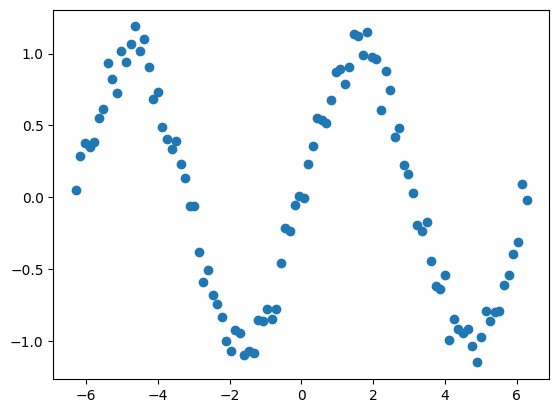

In [70]:
import matplotlib.pyplot as plt
plt.scatter(x,y)
plt.show()

In [71]:
x=x.reshape(-1,1)
y=y.reshape(-1,1)

# Standarize the data
x = (x - jnp.mean(x)) / jnp.std(x)
y = (y - jnp.mean(y)) / jnp.std(y)

In [72]:
import jax

def get_params(in_dim:int,out_dim:int,key:random.key)->tuple[jnp.ndarray,jnp.ndarray]:
    w_key,b_key = random.split(key)
    w = random.normal(w_key,(in_dim,out_dim))
    b = random.normal(b_key,(out_dim,))
    return w,b

def linear(layer_params:tuple[jnp.ndarray,jnp.ndarray],x:jnp.ndarray)->jnp.ndarray:
    w,b = layer_params
    return jnp.dot(x,w)+b

def build_model(layer_sizes:list[int],key:random.key)->list[tuple[jnp.ndarray,jnp.ndarray]]:
    keys = random.split(key,len(layer_sizes))
    params = [get_params(layer_sizes[i],layer_sizes[i+1],keys[i]) for i in range(len(layer_sizes)-1)]
    return params

@jit
def loss_fn(params:list[tuple[jnp.ndarray,jnp.ndarray]],x:jnp.ndarray,y:jnp.ndarray)->jnp.ndarray:
    for w,b in params[:-1]:
        x = linear((w,b),x)
        x = jax.nn.relu(x)

    x=linear(params[-1],x)
    return jnp.mean((x-y)**2)

def train_step(params:list[tuple[jnp.ndarray,jnp.ndarray]],x:jnp.ndarray,y:jnp.ndarray,lr:float)->list[tuple[jnp.ndarray,jnp.ndarray]]:
    value,grads = value_and_grad(loss_fn)(params,x,y)
    return [(w-lr*dw,b-lr*db) for (w,b),(dw,db) in zip(params,grads)]

In [1]:
model=build_model([1,20,50,50,1],random.PRNGKey(0))

for p in model:
    print(p[0].shape,p[1].shape)

NameError: name 'build_model' is not defined

In [74]:
lr=1e-4
epochs=3000
for epoch in range(epochs):
    model = train_step(model,x,y,lr)
    if (epoch+1)%200==0:
        print(f"Epoch {epoch+1} loss: {loss_fn(model,x,y):.5f}\n")

Epoch 200 loss: 1.02722

Epoch 400 loss: 0.18422

Epoch 600 loss: 0.10910

Epoch 800 loss: 0.08233

Epoch 1000 loss: 0.06740

Epoch 1200 loss: 0.05732

Epoch 1400 loss: 0.05059

Epoch 1600 loss: 0.04598

Epoch 1800 loss: 0.04306

Epoch 2000 loss: 0.04092

Epoch 2200 loss: 0.03920

Epoch 2400 loss: 0.03777

Epoch 2600 loss: 0.03651

Epoch 2800 loss: 0.03546

Epoch 3000 loss: 0.03459



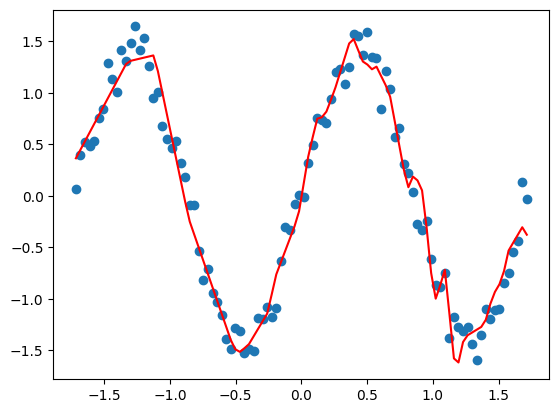

In [75]:
out=x
for p in model[:-1]:
    out=linear(p,out)
    out=jax.nn.relu(out)

out=linear(model[-1],out)

plt.scatter(x,y)
plt.plot(x,out,color='red')
plt.show()